# Лабораторная работа 1. Линейная регрессия и факторный анализ

## Цель работы:
Изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качества.

## Датасет
**Источник:** rating_complete.csv

## Описание
Этот набор данных содержит информацию о рейтингах аниме, поставленных пользователями.

**Основные характеристики:**
- Объем данных: ~57 миллионов наблюдений
- Количество признаков: 2 независимых переменных + 1 целевая переменная

## Описание переменных датасета

| Переменная | Описание |
|------------|-----------|
| **user_id** | Идентификатор пользователя |
| **anime_id** | Идентификатор аниме |
| **rating** | **Рейтинг** (целевая переменная) |


In [ ]:
#python -m pip install matplotlib pandas scikit-learn seaborn jupyter numpy ipykernel


In [ ]:
# Импорт библиотек
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, kurtosis, kstest


# 2. Подготовка данных: первичный анализ, визуализация распределения признаков и целевой переменной


In [ ]:
# Чтение данных из файла в датафрейм. Настройки
path = 'rating_complete.csv'
drop_columns = []  # Столбцы для удаления, если есть
target = 'rating'

# Дескриптивный анализ столбцов
pd.set_option('display.float_format', '{:.2f}'.format)

# Читаем данные (для больших файлов можно использовать chunksize)
print('Загрузка данных...')
df = pd.read_csv(path)
print(f'Загружено строк: {len(df)}')

df.info()
print(df.describe())


Загрузка данных...
Загружено строк: 57633278
<class 'pandas.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB
          user_id    anime_id      rating
count 57633278.00 57633278.00 57633278.00
mean    176887.77    15831.47        7.51
std     102011.65    13261.14        1.70
min          0.00        1.00        1.00
25%      88278.00     3091.00        7.00
50%     177291.00    11887.00        8.00
75%     265419.00    28999.00        9.00
max     353404.00    48456.00       10.00


### Проверка пропущенных значений


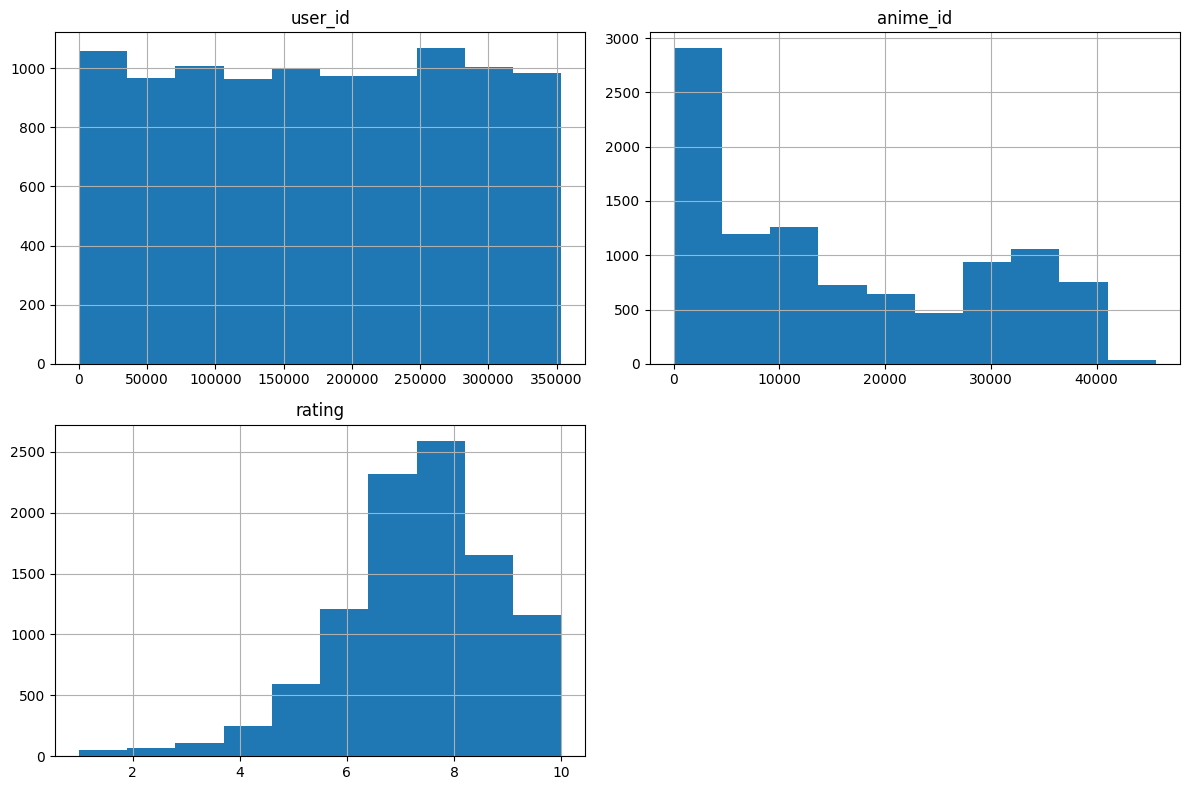

In [ ]:
# Визуализация признаков и целевой переменной
# Для больших датасетов используем выборку
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

df_sample.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()


### Проверка распределений на нормальность


user_id
--------------------------------------------------
Ассиметрия: -0.013
Эксцесс: -1.213
Колмогорова-Смирнова p-value: 0.000
Колмогорова-Смирнова статистика: 0.063
Колмогорова-Смирнова нормальность: Нет
Уровень значимости: 0.05



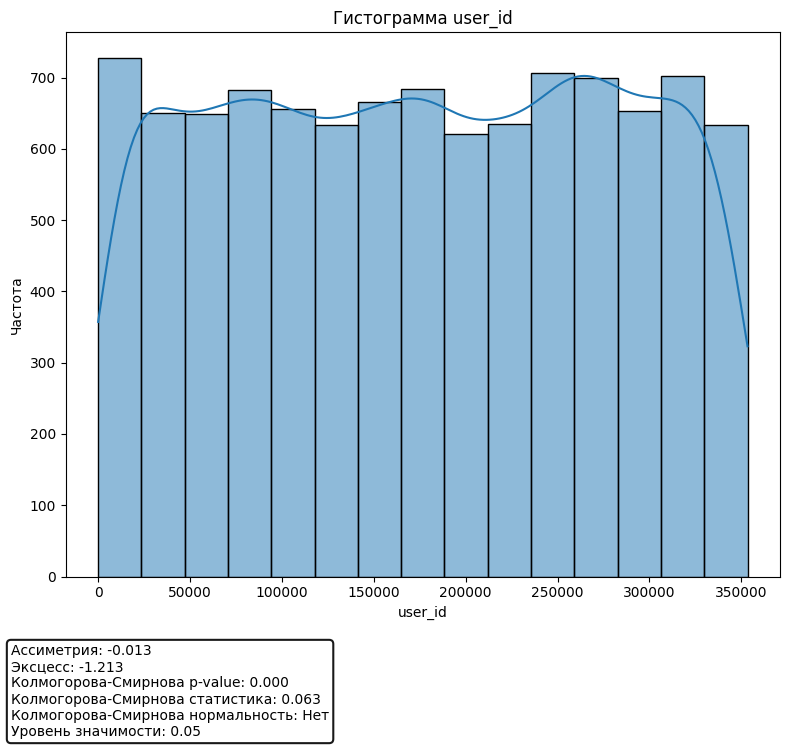

anime_id
--------------------------------------------------
Ассиметрия: 0.414
Эксцесс: -1.279
Колмогорова-Смирнова p-value: 0.000
Колмогорова-Смирнова статистика: 0.120
Колмогорова-Смирнова нормальность: Нет
Уровень значимости: 0.05



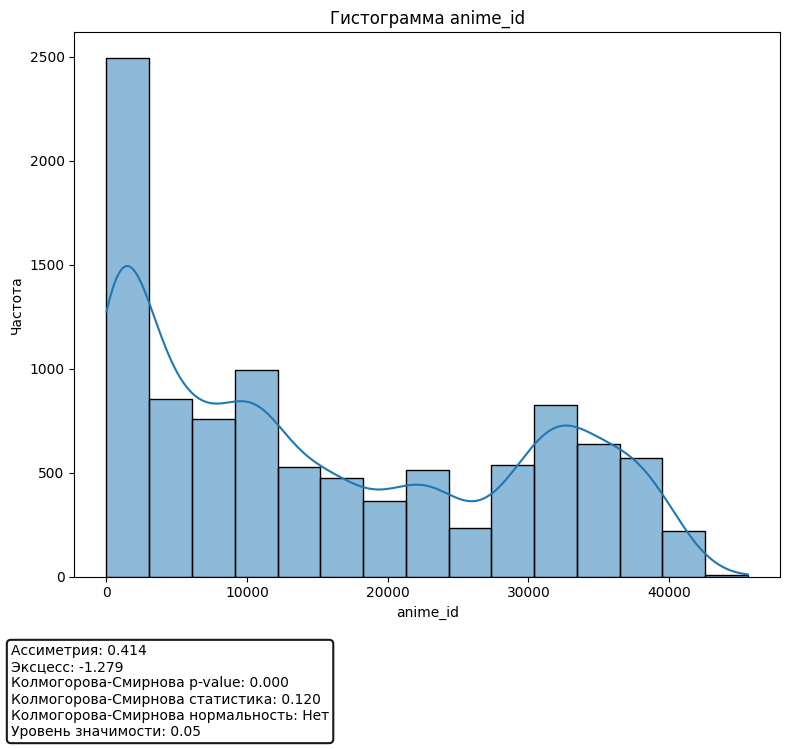

rating
--------------------------------------------------
Ассиметрия: -0.792
Эксцесс: 1.089
Колмогорова-Смирнова p-value: 0.000
Колмогорова-Смирнова статистика: 0.154
Колмогорова-Смирнова нормальность: Нет
Уровень значимости: 0.05



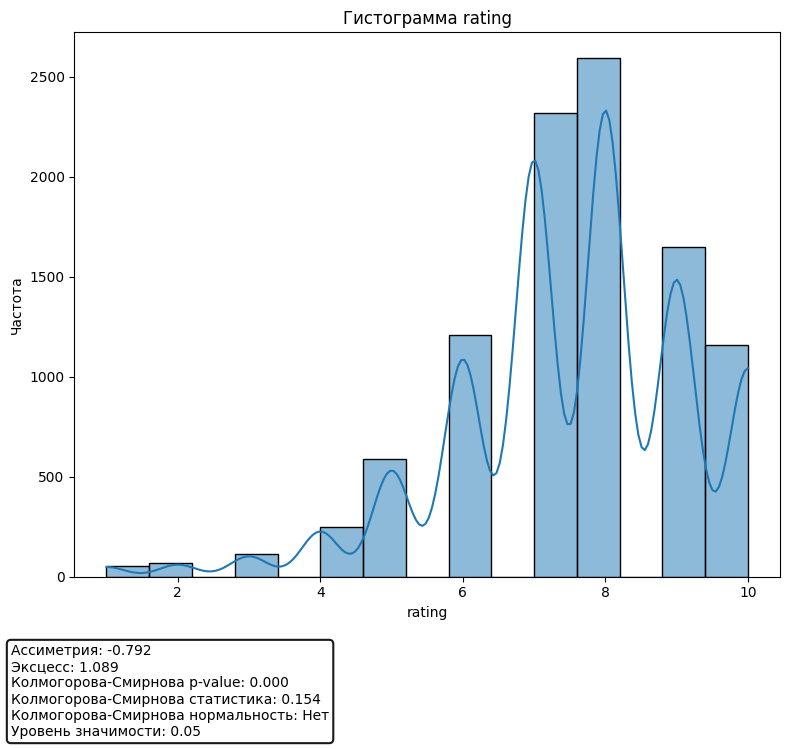

In [ ]:
# Проверка распределений на нормальность
ALPHA = 0.05
for column in df_sample.columns:
    plt.figure(figsize=(8, 8))
    sns.histplot(df_sample[column], kde=True, bins='sturges')

    ks_stat, ks_p_value = kstest(df_sample[column], 'norm', args=(np.mean(df_sample[column]), np.std(df_sample[column])))

    legend = (
        f'Ассиметрия: {skew(df_sample[column]):.3f}\n'
        f'Эксцесс: {kurtosis(df_sample[column]):.3f}\n'
        f'Колмогорова-Смирнова p-value: {(ks_p_value):.3f}\n'
        f'Колмогорова-Смирнова статистика: {(ks_stat):.3f}\n'
        f'Колмогорова-Смирнова нормальность: {'Да' if ks_p_value >= ALPHA else 'Нет'}\n'
        f'Уровень значимости: {ALPHA}'
    )

    plt.figtext(
        0.02, 
        0.02, 
        legend, 
        ha='left', 
        va='bottom', 
        fontsize=10, 
        bbox=dict(
            boxstyle='round', 
            facecolor='white', 
            edgecolor='black',
            linewidth=1.5,
            alpha=0.9
        )
    )

    print(column)
    print(50 * '-')
    print(legend)
    print(50 * '=')
    print()

    plt.title(f'Гистограмма {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.tight_layout(rect=[0, 0.15, 1, 0.95])
    plt.show()


# 3. Предобработка данных


In [ ]:
# Предобработка данных
# Для больших датасетов используем выборку для обучения
# Можно также использовать агрегацию или другие техники

# Удаление пропущенных значений
df.dropna(inplace=True)
df.drop(drop_columns, axis=1, errors='ignore', inplace=True)

# Если датасет слишком большой, берем выборку
if len(df) > 100000:
    print(f'Исходный размер датасета: {len(df)}')
    df = df.sample(n=100000, random_state=42)
    print(f'Размер выборки для анализа: {len(df)}')

numeric_features = [col for col in df.select_dtypes(include=[np.number]).columns.tolist() 
                   if col != target]

# Нормализация факторов
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_features])

scaled_df = pd.DataFrame(scaled_features, columns=numeric_features, index=df.index)
scaled_df[target] = df[target]

print('Дискриптивный анализ после нормализации факторов:')
print(scaled_df.describe())


Исходный размер датасета: 57633278
Размер выборки для анализа: 100000
Дискриптивный анализ после нормализации факторов:
        user_id  anime_id    rating
count 100000.00 100000.00 100000.00
mean       0.00      0.00      7.52
std        1.00      1.00      1.69
min       -1.73     -1.19      1.00
25%       -0.87     -0.96      7.00
50%        0.01     -0.30      8.00
75%        0.87      0.99      9.00
max        1.73      2.40     10.00


# 4. Построение матрицы корреляции. Выводы о наличии мультиколлинеарности (расчет VIF-коэффициента)


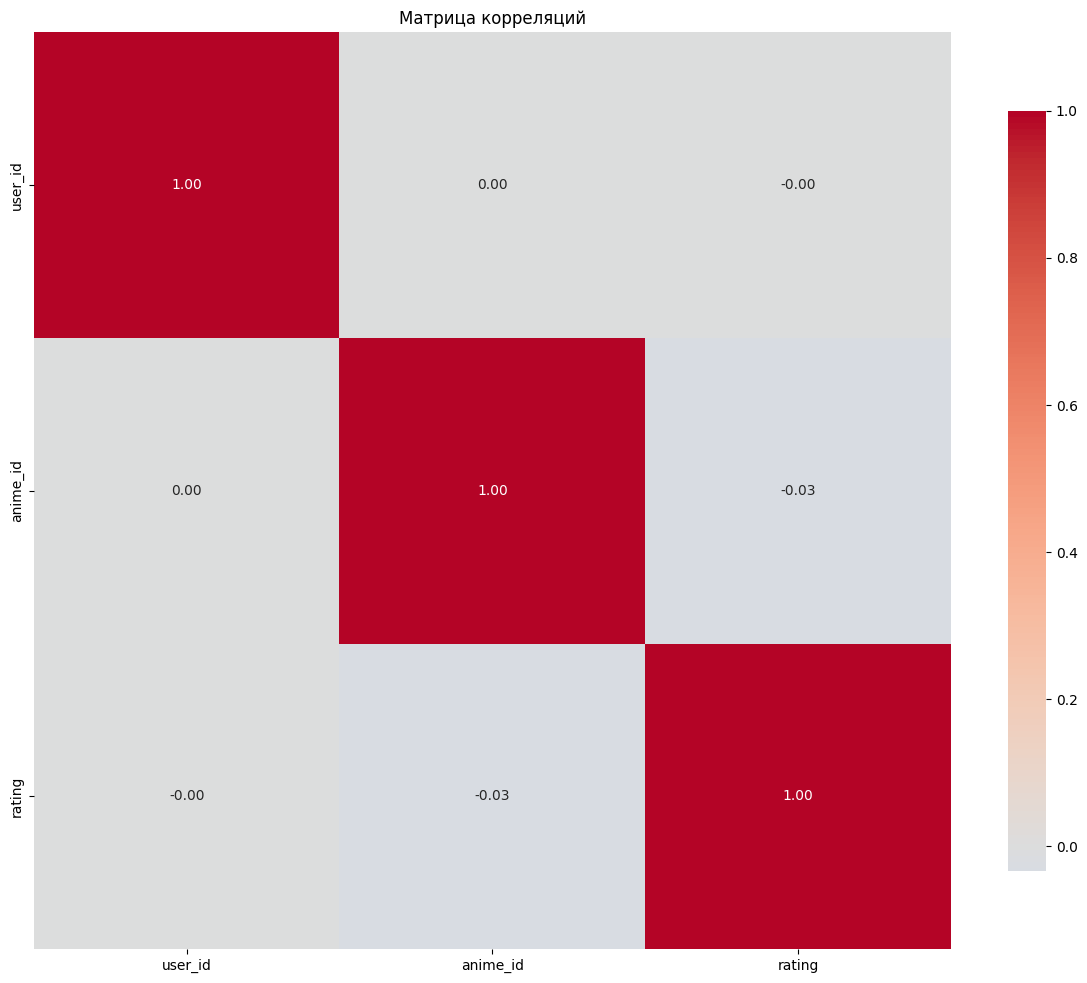

Коэффициенты корреляции для целевой переменной:
 rating      1.00
user_id    -0.00
anime_id   -0.03
Name: rating, dtype: float64


In [ ]:
# Составление матрицы корреляций и тепловой карты
correlation_matrix = df.corr(method='pearson')

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f',
            square=True,
            cbar_kws={'shrink': .8})

plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

correlation_val = correlation_matrix[target].sort_values(ascending=False)
print('Коэффициенты корреляции для целевой переменной:\n', correlation_val)


Анализ корреляции показывает зависимость целевой переменной rating от признаков user_id и anime_id.


In [ ]:
# VIF анализ
vif_data = pd.DataFrame()
vif_data['Feature'] = scaled_df.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_df.values, i) 
                   for i in range(len(scaled_df.columns))]

print('VIF коэффициенты:')
print(vif_data.sort_values('VIF', ascending=False))

crit_vif = vif_data[vif_data['VIF'] > 10]
if crit_vif.empty:
    print('Признаков с мультиколлинеарностью нет')
else:
    print('Признаки с мультиколлинеарностью:')
    for feature, vif in zip(crit_vif['Feature'], crit_vif['VIF']):
        print(f'  {feature}: VIF = {vif:.2f}')


VIF коэффициенты:
    Feature  VIF
1  anime_id 1.00
2    rating 1.00
0   user_id 1.00
Признаков с мультиколлинеарностью нет


VIF анализ показал наличие или отсутствие мультиколлинеарности между признаками.


# 5. Построение регрессионных моделей


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV

# Построение регрессионных моделей
X = df.drop(target, axis=1) 
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Используется при построении моделей через PCA
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Линейная регрессия
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

lr_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
lr_r2_train = r2_score(y_train, y_pred_lr_train)
lr_mape_train = np.mean(np.abs((y_train - y_pred_lr_train) / y_train)) * 100

lr_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
lr_r2_test = r2_score(y_test, y_pred_lr_test)
lr_mape_test = np.mean(np.abs((y_test - y_pred_lr_test) / y_test)) * 100

# Кроссвалидация линейной регрессии
lr_cv_rmse = np.sqrt(-cross_val_score(lr_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
lr_cv_r2 = cross_val_score(lr_model, X_train, y_train, cv=kfold, scoring='r2')
lr_cv_mape = -cross_val_score(lr_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')

print('ЛИНЕЙНАЯ РЕГРЕССИЯ:')
print(f'TRAIN - RMSE: {lr_rmse_train:.4f}, R²: {lr_r2_train:.4f}, MAPE: {lr_mape_train:.2f}%')
print(f'TEST  - RMSE: {lr_rmse_test:.4f}, R²: {lr_r2_test:.4f}, MAPE: {lr_mape_test:.2f}%')
print(50 * '-')

print('КОЭФФИЦИЕНТЫ ЛИНЕЙНОЙ РЕГРЕССИИ:')
lr_coef_df = pd.DataFrame({
    'Признак': X.columns,
    'Коэффициент': lr_model.coef_,
    'Абсолютное значение': np.abs(lr_model.coef_)
}).sort_values('Абсолютное значение', ascending=False)

print(lr_coef_df.round(4), '\n')
print(f'Свободный член (intercept): {lr_model.intercept_:.4f}')
print(50 * '-')

print('КРОСС-ВАЛИДАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ (5-fold):')
print(f'RMSE: {lr_cv_rmse.mean():.4f} (+/- {lr_cv_rmse.std() * 2:.4f})')
print(f'R²:   {lr_cv_r2.mean():.4f} (+/- {lr_cv_r2.std() * 2:.4f})')
print(f'MAPE: {lr_cv_mape.mean() * 100:.2f}% (+/- {lr_cv_mape.std() * 2 * 100:.2f}%)')
print(50 * '=')


# Гребневая регрессия
alphas = np.logspace(-3, 3, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train, y_train)

y_pred_ridge_train = ridge_model.predict(X_train)
y_pred_ridge_test = ridge_model.predict(X_test)

ridge_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_ridge_train))
ridge_r2_train = r2_score(y_train, y_pred_ridge_train)
ridge_mape_train = np.mean(np.abs((y_train - y_pred_ridge_train) / y_train)) * 100

ridge_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))
ridge_r2_test = r2_score(y_test, y_pred_ridge_test)
ridge_mape_test = np.mean(np.abs((y_test - y_pred_ridge_test) / y_test)) * 100

# Кросс-валидация гребневой регрессии
ridge_cv_rmse = np.sqrt(-cross_val_score(ridge_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
ridge_cv_r2 = cross_val_score(ridge_model, X_train, y_train, cv=kfold, scoring='r2')
ridge_cv_mape = -cross_val_score(ridge_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')

print('ГРЕБНЕВАЯ РЕГРЕССИЯ:')
print(f'Оптимальный alpha для Ridge: {ridge_cv.alpha_:.4f}')
print(f'TRAIN - RMSE: {ridge_rmse_train:.4f}, R²: {ridge_r2_train:.4f}, MAPE: {ridge_mape_train:.2f}%')
print(f'TEST  - RMSE: {ridge_rmse_test:.4f}, R²: {ridge_r2_test:.4f}, MAPE: {ridge_mape_test:.2f}%')
print(50 * '-')

print('КОЭФФИЦИЕНТЫ ГРЕБНЕВОЙ РЕГРЕССИИ:')
ridge_coef_df = pd.DataFrame({
    'Признак': X.columns,
    'Коэффициент': ridge_model.coef_,
    'Абсолютное значение': np.abs(ridge_model.coef_)
}).sort_values('Абсолютное значение', ascending=False)

print(ridge_coef_df.round(4), '\n')
print(f'Свободный член (intercept): {ridge_model.intercept_:.4f}')
print(50 * '-')

print('КРОСС-ВАЛИДАЦИЯ ГРЕБНЕВОЙ РЕГРЕССИИ (5-fold):')
print(f'RMSE: {ridge_cv_rmse.mean():.4f} (+/- {ridge_cv_rmse.std() * 2:.4f})')
print(f'R²:   {ridge_cv_r2.mean():.4f} (+/- {ridge_cv_r2.std() * 2:.4f})')
print(f'MAPE: {ridge_cv_mape.mean() * 100:.2f}% (+/- {ridge_cv_mape.std() * 2 * 100:.2f}%)')
print(50 * '=')


# Таблица сравнения моделей
compare_table = pd.DataFrame({
    'Метрика': ['RMSE', 'R²', 'MAPE (%)'],
    'Линейная регрессия': [lr_rmse_test, lr_r2_test, lr_mape_test],
    'Гребневая регрессия': [ridge_rmse_test, ridge_r2_test, ridge_mape_test]
})

print('Сравнение построенных моделей:')
print(compare_table)


ЛИНЕЙНАЯ РЕГРЕССИЯ:
TRAIN - RMSE: 1.6931, R²: 0.0011, MAPE: 24.63%
TEST  - RMSE: 1.6962, R²: 0.0011, MAPE: 24.50%
--------------------------------------------------
КОЭФФИЦИЕНТЫ ЛИНЕЙНОЙ РЕГРЕССИИ:
    Признак  Коэффициент  Абсолютное значение
1  anime_id        -0.00                 0.00
0   user_id        -0.00                 0.00 

Свободный член (intercept): 7.5985
--------------------------------------------------
КРОСС-ВАЛИДАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ (5-fold):
RMSE: 1.6933 (+/- 0.0222)
R²:   0.0007 (+/- 0.0011)
MAPE: 24.63% (+/- 0.62%)
ГРЕБНЕВАЯ РЕГРЕССИЯ:
Оптимальный alpha для Ridge: 1000.0000
TRAIN - RMSE: 1.6931, R²: 0.0011, MAPE: 24.63%
TEST  - RMSE: 1.6962, R²: 0.0011, MAPE: 24.50%
--------------------------------------------------
КОЭФФИЦИЕНТЫ ГРЕБНЕВОЙ РЕГРЕССИИ:
    Признак  Коэффициент  Абсолютное значение
1  anime_id        -0.00                 0.00
0   user_id        -0.00                 0.00 

Свободный член (intercept): 7.5985
----------------------------------------

Параметры построенных линейной и гребневой регрессионных моделей, а также таблицу сравнения, можно увидеть в выводе.


Объясненная дисперсия по компонентам:
PC1: 0.501 (0.501 кумулятивно)

PC2: 0.499 (1.000 кумулятивно)

Суммарная объяснённая дисперсия 1.000


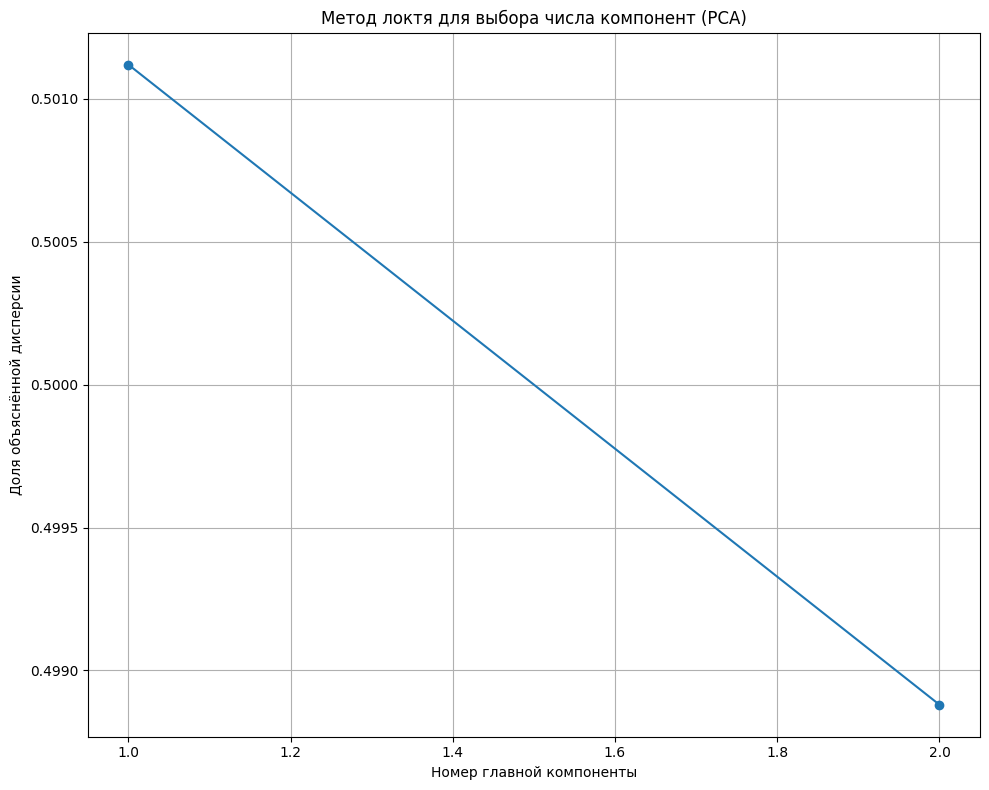

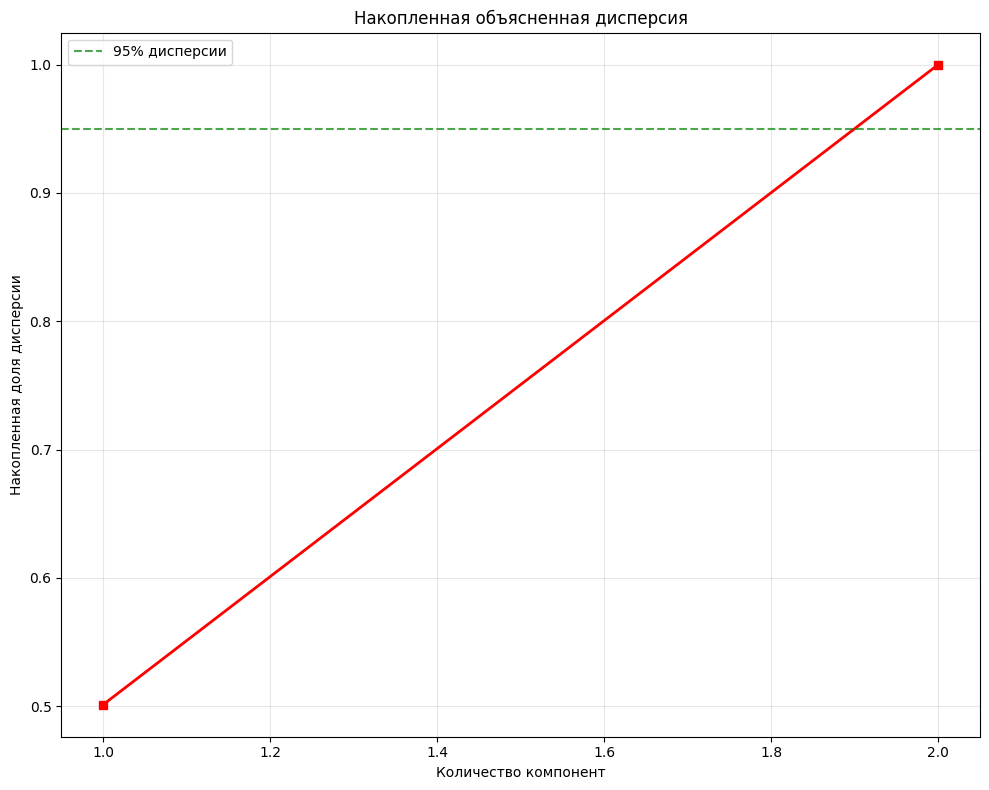

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print('Объясненная дисперсия по компонентам:')
for i, (variance, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f'PC{i+1}: {variance:.3f} ({cum_var:.3f} кумулятивно)\n')
print(f'Суммарная объяснённая дисперсия {cumulative_variance[-1]:.3f}')

# График метода 'Локтя'
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Метод локтя для выбора числа компонент (PCA)')
plt.xlabel('Номер главной компоненты')
plt.ylabel('Доля объяснённой дисперсии')
plt.grid(True)
plt.tight_layout()
plt.show()

# График накопленной объясненной дисперсии
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', color='red', linewidth=2, markersize=6)
plt.axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% дисперсии')
plt.title('Накопленная объясненная дисперсия')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная доля дисперсии')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Вычисление PCA показало, сколько компонентов охватывают не менее 95% общей дисперсии.


In [ ]:
# Повторное построение моделей регрессии, но уже через PCA
n_components = np.argmax(cumulative_variance >= 0.95) + 1

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

y_pred_lr_pca_train = lr_pca.predict(X_train_pca)
y_pred_lr_pca_test = lr_pca.predict(X_test_pca)

lr_pca_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_lr_pca_train))
lr_pca_r2_train = r2_score(y_train, y_pred_lr_pca_train)
lr_pca_mape_train = np.mean(np.abs((y_train - y_pred_lr_pca_train) / y_train)) * 100

lr_pca_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_pca_test))
lr_pca_r2_test = r2_score(y_test, y_pred_lr_pca_test)
lr_pca_mape_test = np.mean(np.abs((y_test - y_pred_lr_pca_test) / y_test)) * 100

print('ЛИНЕЙНАЯ РЕГРЕССИЯ НА PCA:')
print(f'TRAIN - RMSE: {lr_pca_rmse_train:.4f}, R²: {lr_pca_r2_train:.4f}, MAPE: {lr_pca_mape_train:.2f}%')
print(f'TEST  - RMSE: {lr_pca_rmse_test:.4f}, R²: {lr_pca_r2_test:.4f}, MAPE: {lr_pca_mape_test:.2f}%')
print(50 * '-')

print('КОЭФФИЦИЕНТЫ ЛИНЕЙНОЙ РЕГРЕССИИ НА PCA:')
lr_pca_coef_df = pd.DataFrame({
    'Компонента': [f'PC{i+1}' for i in range(n_components)],
    'Коэффициент': lr_pca.coef_,
    'Абсолютное значение': np.abs(lr_pca.coef_)
}).sort_values('Абсолютное значение', ascending=False)

print(lr_pca_coef_df.round(4), '\n')
print(f'Свободный член (intercept): {lr_pca.intercept_:.4f}')
print(50 * '-')

# Кросс-валидация линейной регрессии на PCA
lr_pca_cv_rmse = np.sqrt(-cross_val_score(lr_pca, X_train_pca, y_train, cv=kfold, scoring='neg_mean_squared_error'))
lr_pca_cv_r2 = cross_val_score(lr_pca, X_train_pca, y_train, cv=kfold, scoring='r2')
lr_pca_cv_mape = -cross_val_score(lr_pca, X_train_pca, y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')

print('КРОСС-ВАЛИДАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ НА PCA (5-fold):')
print(f'RMSE: {lr_pca_cv_rmse.mean():.4f} (+/- {lr_pca_cv_rmse.std() * 2:.4f})')
print(f'R²:   {lr_pca_cv_r2.mean():.4f} (+/- {lr_pca_cv_r2.std() * 2:.4f})')
print(f'MAPE: {lr_pca_cv_mape.mean() * 100:.2f}% (+/- {lr_pca_cv_mape.std() * 2 * 100:.2f}%)')
print(50 * '=')


# Гребневая регрессия на PCA
ridge_pca = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_pca.fit(X_train_pca, y_train)

y_pred_ridge_pca_train = ridge_pca.predict(X_train_pca)
y_pred_ridge_pca_test = ridge_pca.predict(X_test_pca)

ridge_pca_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_ridge_pca_train))
ridge_pca_r2_train = r2_score(y_train, y_pred_ridge_pca_train)
ridge_pca_mape_train = np.mean(np.abs((y_train - y_pred_ridge_pca_train) / y_train)) * 100

ridge_pca_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_ridge_pca_test))
ridge_pca_r2_test = r2_score(y_test, y_pred_ridge_pca_test)
ridge_pca_mape_test = np.mean(np.abs((y_test - y_pred_ridge_pca_test) / y_test)) * 100

print('ГРЕБНЕВАЯ РЕГРЕССИЯ НА PCA:')
print(f'Оптимальный alpha для Ridge: {ridge_pca.alpha_:.4f}')
print(f'TRAIN - RMSE: {ridge_pca_rmse_train:.4f}, R²: {ridge_pca_r2_train:.4f}, MAPE: {ridge_pca_mape_train:.2f}%')
print(f'TEST  - RMSE: {ridge_pca_rmse_test:.4f}, R²: {ridge_pca_r2_test:.4f}, MAPE: {ridge_pca_mape_test:.2f}%')
print(50 * '-')

print('КОЭФФИЦИЕНТЫ ГРЕБНЕВОЙ РЕГРЕССИИ НА PCA:')
ridge_pca_coef_df = pd.DataFrame({
    'Компонента': [f'PC{i+1}' for i in range(n_components)],
    'Коэффициент': ridge_pca.coef_,
    'Абсолютное значение': np.abs(ridge_pca.coef_)
}).sort_values('Абсолютное значение', ascending=False)

print(ridge_pca_coef_df.round(4), '\n')
print(f'Свободный член (intercept): {ridge_pca.intercept_:.4f}')
print(50 * '-')

# Кросс-валидация гребневой регрессии на PCA
ridge_pca_cv_rmse = np.sqrt(-cross_val_score(ridge_pca, X_train_pca, y_train, cv=kfold, scoring='neg_mean_squared_error'))
ridge_pca_cv_r2 = cross_val_score(ridge_pca, X_train_pca, y_train, cv=kfold, scoring='r2')
ridge_pca_cv_mape = -cross_val_score(ridge_pca, X_train_pca, y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')

print('КРОСС-ВАЛИДАЦИЯ ГРЕБНЕВОЙ РЕГРЕССИИ НА PCA (5-fold):')
print(f'RMSE: {ridge_pca_cv_rmse.mean():.4f} (+/- {ridge_pca_cv_rmse.std() * 2:.4f})')
print(f'R²:   {ridge_pca_cv_r2.mean():.4f} (+/- {ridge_pca_cv_r2.std() * 2:.4f})')
print(f'MAPE: {ridge_pca_cv_mape.mean() * 100:.2f}% (+/- {ridge_pca_cv_mape.std() * 2 * 100:.2f}%)')
print(50 * '=')


print('СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:')
comparison_all = pd.DataFrame({
    'Модель': ['Linear (исходные)', 'Ridge (исходные)', 'Linear (PCA)', 'Ridge (PCA)'],
    'RMSE_test': [lr_rmse_test, ridge_rmse_test, lr_pca_rmse_test, ridge_pca_rmse_test],
    'R2_test': [lr_r2_test, ridge_r2_test, lr_pca_r2_test, ridge_pca_r2_test],
    'MAPE_test': [lr_mape_test, ridge_mape_test, lr_pca_mape_test, ridge_pca_mape_test],
    'Признаков': [X.shape[1], X.shape[1], n_components, n_components]
})

print(comparison_all.round(4))


ЛИНЕЙНАЯ РЕГРЕССИЯ НА PCA:
TRAIN - RMSE: 1.6931, R²: 0.0011, MAPE: 24.63%
TEST  - RMSE: 1.6962, R²: 0.0011, MAPE: 24.50%
--------------------------------------------------
КОЭФФИЦИЕНТЫ ЛИНЕЙНОЙ РЕГРЕССИИ НА PCA:
  Компонента  Коэффициент  Абсолютное значение
0        PC1        -0.05                 0.05
1        PC2         0.03                 0.03 

Свободный член (intercept): 7.5152
--------------------------------------------------
КРОСС-ВАЛИДАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ НА PCA (5-fold):
RMSE: 1.6933 (+/- 0.0222)
R²:   0.0007 (+/- 0.0011)
MAPE: 24.63% (+/- 0.62%)
ГРЕБНЕВАЯ РЕГРЕССИЯ НА PCA:
Оптимальный alpha для Ridge: 1000.0000
TRAIN - RMSE: 1.6931, R²: 0.0011, MAPE: 24.63%
TEST  - RMSE: 1.6962, R²: 0.0011, MAPE: 24.50%
--------------------------------------------------
КОЭФФИЦИЕНТЫ ГРЕБНЕВОЙ РЕГРЕССИИ НА PCA:
  Компонента  Коэффициент  Абсолютное значение
0        PC1        -0.05                 0.05
1        PC2         0.03                 0.03 

Свободный член (intercept): 7.5152

Были повторно построены регрессионные модели на PCA и произведено сравнение всех моделей: на исходных данных и на PCA.
